In [ ]:
# Here we import everything we need for the project

%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.18.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import zipfile
import os

zip_path = '/content/gesture.zip'  # or your path
extract_path = '/content/gesture'  # or your desired path

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [13]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False):
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

20000


In [14]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


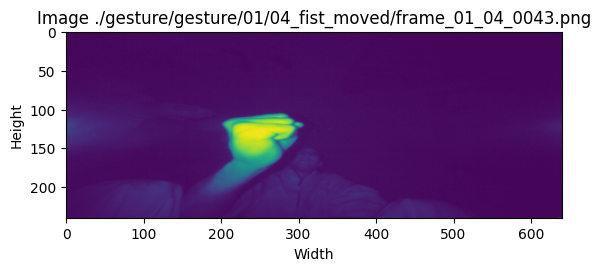

In [15]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

In [16]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)

  # Processing label in image path
  category = path.split("/")[3]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  20000
Labels loaded:  20000
1 ./gesture/gesture/01/04_fist_moved/frame_01_04_0043.png


In [17]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [27]:
# Recreate the exact same model, including weights and optimizer.
# model = keras.models.load_model('handrecognition_model.h5')
# model.summary()

# To use the pre-trained model, just load it and skip to the next session.

In [51]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Input(shape=(120, 320, 1)),  # Corrected input shape
    Conv2D(16, (3,3), activation='relu'), # Reduced filters
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'), # Added another conv layer
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 gesture classes based on data
])

In [38]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [39]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
219/219 - 503s - 2s/step - accuracy: 0.8954 - loss: 11.0194 - val_accuracy: 0.9890 - val_loss: 0.0330
Epoch 2/5
219/219 - 476s - 2s/step - accuracy: 0.9912 - loss: 0.0211 - val_accuracy: 0.9935 - val_loss: 0.0142
Epoch 3/5
219/219 - 532s - 2s/step - accuracy: 0.9909 - loss: 0.0152 - val_accuracy: 0.9917 - val_loss: 0.0155
Epoch 4/5
219/219 - 554s - 3s/step - accuracy: 0.9925 - loss: 0.0135 - val_accuracy: 0.9917 - val_loss: 0.0154
Epoch 5/5
219/219 - 501s - 2s/step - accuracy: 0.9919 - loss: 0.0141 - val_accuracy: 0.9917 - val_loss: 0.0145


In [50]:
# Save entire model to a HDF5 file
model.save('my_model.keras')

In [41]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - accuracy: 0.9920 - loss: 0.0147
Test accuracy: 99.17%


In [42]:
predictions = model.predict(X_test) # Make predictions towards the test set

188/188 ━━━━━━━━━━━━━━━━━━━━ 53s 280ms/step


In [43]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(np.int64(7), np.int64(7))

In [44]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"]
  plt.figure(figsize=(15,5))

  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction

    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

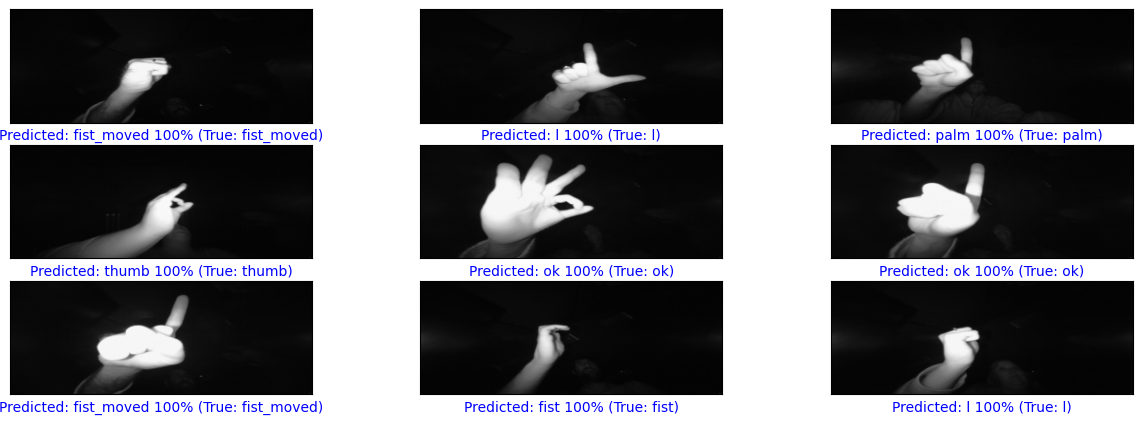

In [45]:
validate_9_images(predictions, y_test, X_test)

In [46]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [47]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,618,0,0,0,0,0,0,0,0,0
Actual Palm (H),0,565,0,0,0,0,0,0,0,0
Actual L,0,0,596,0,0,31,0,0,0,1
Actual Fist (H),0,0,0,583,0,0,0,0,0,0
Actual Fist (V),0,0,0,0,624,0,0,0,0,0
Actual Thumbs up,0,0,15,0,0,603,0,0,0,0
Actual Index,0,0,0,0,0,0,610,0,0,0
Actual OK,0,0,0,0,0,0,2,582,0,0
Actual Palm (V),0,0,0,0,0,0,0,1,589,0
Actual C,0,0,0,0,0,0,0,0,0,580
